MCS - BeNeFri
<br/>Social Media Analytics, Spring 2020
<br/>Project - Community Detection in a Facebook network
<br/>@authors: Guillaume Chacun, Fabien Vorpe

# Community Detection in a Facebook network

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from random import randrange, choices
import statistics
from tqdm import tqdm

## Dataset

### Load the graph

In [2]:
edges_filename = 'facebook_combined.txt' #facebook_combined

In [3]:
# Load the Facebook dataset
graph = nx.read_edgelist(f'data/{edges_filename}')
#graph = nx.gnp_random_graph(200, 0.2)

edge_list = ['%i %i {\'weight\': %i}' % (int(d[0]), int(d[1]), int(d[2])) for d in list(graph.edges.data('weight', default=1))]
graph = nx.parse_edgelist(edge_list)

### Explore the properties of the graph

In [4]:
print('Number of nodes:', graph.number_of_nodes())
print('Number of edges:', graph.number_of_edges())

Number of nodes: 4039
Number of edges: 88234


In [5]:
print('Average shortest path length:', nx.average_shortest_path_length(graph))
print('Average degree:', statistics.mean([graph.degree(node) for node in graph.nodes()]))

Average shortest path length: 3.6925068496963913
Average degree: 43.69101262688784


In [6]:
print('Radius:', nx.radius(graph))
print('Diameter:', nx.diameter(graph))
print('Density:', nx.density(graph))

Radius: 4
Diameter: 8
Density: 0.010819963503439287


## Algorithms implementation

### Louvain

Implement the Louvain method for community detection.  

In [7]:
def louvain_passage(graph):
    """
    Performs one passage of Louvain's algorithm to detect communities in a graph.
    :param graph: networkx graph
    :returns: dictionary with graph's nodes as keys and communities' id as values
    """
    m = sum([edge[2]['weight'] for edge in graph.edges().data()])
    prev_communities = {}
    communities = {i: i for i in graph.nodes} # keys: nodes' id, values: nodes' community id
    while list(prev_communities.values()) != list(communities.values()): # while communities are changing
        prev_communities = communities.copy()
        
        communities = {k: v for k, v in sorted(communities.items(), 
                                               key=lambda item: int(item[1]))} # sort by node id (keys)
        for nodei in tqdm(communities.keys()):
            communityi = communities[nodei]
            di = sum([graph.get_edge_data(nodei, neighbor)['weight']
                      for neighbor in graph.neighbors(nodei)])
            # can't use degree() as we're working with undirected graphs and degree() counts self loops twice
            
            neighbor_communities = set(communities[neighbor] for neighbor in graph.neighbors(nodei))
            
            # compute modularity gain for each neighbor community of nodei
            modularity_gains = {} # keys: community' id, values: modularity gain
            
            nodes_of_each_community = {}
            for node, community in communities.items():
                try:
                    nodes_of_each_community[community].append(node)
                except:
                    nodes_of_each_community[community] = [node]
                    
            for communityj in neighbor_communities:
                nodes_in_communityj = nodes_of_each_community[communityj] # get nodes belonging to community j
                
                dj = 0
                links_ij = []
                for node in nodes_in_communityj:
                    dj += sum([graph.get_edge_data(node, neighbor)['weight'] 
                               for neighbor in graph.neighbors(node) 
                               if node != nodei])
                    
                    # count number of neighbors of nodei that are in communityj
                    links_ij.append(graph.get_edge_data(nodei, node)['weight'] if node in graph.neighbors(nodei) else 0)
                
                dij = 2 * sum(links_ij)
                
                # compute modularity gains
                modularity_gains[communityj] = 1 / (2 * m) * (dij - (di * dj / m))
                
            # update node's community
            modularity_gains = {k: v 
                                for k, v in sorted(modularity_gains.items(), 
                                                   key=lambda item: item[1])} # sort by modularity gain (values)
            communities[nodei] = list(modularity_gains.keys())[-1]
    return communities

In [8]:
def louvain_create_hypernodes(graph, communities):
    """
    Creates the hypernodes graph after one passage of Louvain's aglorithm.
    :param graph: networkx graph
    :param communities: dictionary with graph's nodes as keys and communityies' id as values
    :returns: new networkx graph (communities became hypernodes)
    """
    new_graph = nx.Graph()
    # create hypernodes and reflective edges
    for community in set(communities.values()):
        new_graph.add_node(community)

        # count number of edges in community
        nodes_in_community = [n for n, c in communities.items() if community == c]
        
        # get edges' weights for edges within the community
        links_intra_community = [graph.get_edge_data(node, neighbor)['weight'] if neighbor in nodes_in_community else 0 
                                 for node in nodes_in_community
                                 for neighbor in graph.neighbors(node)]
        
        new_graph.add_edge(community, community, weight=sum(links_intra_community)/2) # create the self loop

    # get the nodes of each community
    nodes_in_each_community = {} # keys: communities, values: nodes of community
    for node, community in communities.items():
        try:
            nodes_in_each_community[community].append(node)
        except:
            nodes_in_each_community[community] = [node]
            
    # get the edges of each community
    edges_from_each_community = {} # keys: communities, values: edges which have at least one of their linked nodes in the community
    for node1, node2, data in graph.edges.data():
        for community in nodes_in_each_community.keys():
            if node1 in nodes_in_each_community[community] or node2 in nodes_in_each_community[community]:
                try:
                    edges_from_each_community[community].append((node1, node2, data['weight']))
                except:
                    edges_from_each_community[community] = [(node1, node2, data['weight'])]
    
    # create inter communities edges
    for community in new_graph.nodes:
        nodes_in_community = nodes_in_each_community[community]
        
        for other_community in set(communities.values()):
            if other_community != community:
                nodes_in_other_community = nodes_in_each_community[other_community]
                
                # get edges linking a node of community and a node of other_community
                shared_edges = set(edges_from_each_community[community]) & set(edges_from_each_community[other_community])
                edge_weight = sum([weight for _,_,weight in shared_edges])
                
                if other_community not in new_graph.neighbors(community) and edge_weight > 0:
                    new_graph.add_edge(community, other_community, weight=edge_weight) # create edge between hypernodes
    return new_graph

In [9]:
def louvain(graph):
    """
    Louvain's algorithm to detect communities in a given graph.
    :param graph: networkx graph
    :returns: graph of communities, a dictionary with hypernodes as keys and communities' id as values and 
              a dictionary with graph's nodes as keys and communities' id as values
    """
    all_communities_hypernodes = []
    all_communities_nodes = [{node: node for node in list(graph.nodes())}]
    communities_id = set(graph.nodes())
    passage_id = 0
    while True: # passage
        communities = louvain_passage(graph)
        all_communities_hypernodes.append(communities)

        # check if there was a change in the communities
        if communities_id == set(communities.values()):
            break
        communities_id = set(communities.values())
        
        new_passage_communities = {node: all_communities_hypernodes[passage_id][all_communities_nodes[passage_id][node]] 
                                   for node in all_communities_nodes[passage_id].keys()}
        all_communities_nodes.append(new_passage_communities)
        
        graph = louvain_create_hypernodes(graph, communities)
        
        passage_id += 1
        print('Graph after passage', passage_id, ' (without edges\' weights and self loops)')
        draw_graph(graph)
        
    return graph, all_communities_hypernodes, all_communities_nodes[1:]

### Clustering coefficient
Implement the clustering coefficient for a graph.

In [10]:
def average_clustering_coefficient(graph):
    """
    Computes the average clustering coefficient for a given graph.
    :param graph: networkx graph
    :returns: the average clustering coefficient of the given graph
    """
    return statistics.mean(clustering_coefficient(graph).values())

In [11]:
def clustering_coefficient(graph, top_k=None):
    """
    Computes the clustering coefficient for each node in a given graph.
    :param graph: networkx graph
    :param top_k: top k nodes with highest clustering coefficient to return. If None returns all users.
    :returns: dictionary with graph's nodes as keys and their clustering coefficient as values
    """
    coeffs = {}
    for v in graph.nodes(): # compute coeff for each node
        neighbors = list(graph.neighbors(v))
        
        connected_pairs_neighbors = []
        for n1 in neighbors: # for each neighbor n1 of node v
            for n2 in graph.neighbors(n1): # for each neighbor n2 of neighbor n1 of node v
                if n2 in neighbors: # if n2 is also a neighbor of node v: (n1,n2) is a connected pair of v's neighbors
                    connected_pairs_neighbors.append((n1, n2))
        # C(v) = #connected pairs of v's neighbors / #pairs of v's neighbors
        nb_pairs_neighnbors = (len(neighbors) * (len(neighbors)-1))
        coeffs[v] = len(connected_pairs_neighbors) / nb_pairs_neighnbors if nb_pairs_neighnbors > 0 else 0
        
    coeffs = {k: v 
              for k, v in sorted(coeffs.items(), 
                                 key=lambda item: item[1], 
                                 reverse=True)} # order by coeffs (values)
    return dict(list(coeffs.items())[:top_k if top_k else -1])

In [12]:
def plot_clustering_coefficients_distribution(coeffs, coeffs_slices_width=5):
    """
    Plots the clustering coefficients distribution.
    :param coeffs: dictionary with graph's nodes as keys and their clustering coefficient as values
    :param coeffs_slices_width: width of a distribution slice (integer between 0 and 100)
    """
    if 100 % coeffs_slices_width != 0 or coeffs_slices_width < 0 or coeffs_slices_width > 100:
        coeffs_slices_width = 5
        print('Given width of a distribution slice is invalid. Using default value: 5%.')
    nodes_per_clustering_coeffs = {i: 
                                   len([node for node, coeff in coeffs.items()
                                    if coeff*100 >= i and coeff*100 < i+coeffs_slices_width]) 
                                   for i in range(0, 100, coeffs_slices_width)}
    fig = plt.figure(figsize=(14, 6), dpi= 80)
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Clustering coefficients distribution')
    ax.set_xlabel('Clustering coefficients in percentage')
    ax.set_ylabel('Frequency')
    ax.bar(list(nodes_per_clustering_coeffs.keys()), list(nodes_per_clustering_coeffs.values()), width=coeffs_slices_width, alpha=0.5, align='edge')
    plt.show()

### Random walk

In [13]:
def percentage_visited_communities(visited_nodes, communities):
    """
    Computes the percentages of visited communities from the given list of visited nodes.
    :param visited_nodes: list of visited nodes
    :param communities: dictionary with nodes as keys and communities as values
    :returns: percentage of visited communities
    """
    return len(set(communities[node] for node in visited_nodes)) / len(set(communities.values())) * 100

In [14]:
def random_walk(graph, starting_node, steps, random_walk_strategy):
    """
    Visits a graph with a given random walk strategy.
    :param graph: networkx graph
    :param starting_node: node of the given graph which serves as the starting point of the random walk
    :param steps: number of steps to perform
    :param random_walk_strategy: function receiving a graph and a node and returning a node's neighbor to visit
    :returns: list of nodes in their order of visit
    """
    path = [starting_node]
    node = path[0]
    for _ in range(steps):
        node = random_walk_strategy(graph, node)
        path.append(node)
    return path

In [15]:
def rw_strategy_degree(graph, node):
    """
    Random walk strategy - the degree of a neighbor influences the probability to move to this neighbor.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    probs = [graph.degree(neighbor) for neighbor in neighbors]
    probs = [p/sum(probs) for p in probs]
    return choices(list(neighbors), probs)[0]

In [28]:
def rw_strategy_random(graph, node):
    """
    Random walk strategy - completely random.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    if len(neighbors) == 1:
        return neighbors[0]
    rdm_idx = randrange(len(neighbors)-1)
    return neighbors[rdm_idx]

In [17]:
def rw_strategy_connected_neighbors(graph, node):
    """
    Random walk strategy - the inverse number of connected neighbors influences the probability to move to this neighbor.
    :param graph: networkx graph
    :param node: node of the given graph from which we search a neighbor to move to
    :returns: node's neighbor to move to
    """
    neighbors = list(graph.neighbors(node))
    probs = [len([neighbor_of_neighbor 
                  for neighbor_of_neighbor in list(graph.neighbors(neighbor)) 
                  if neighbor_of_neighbor in neighbors]) 
             for neighbor in neighbors]
    probs = [sum(probs)-p for p in probs]
    probs = [p/sum(probs) if sum(probs) > 0 else 1/len(probs) for p in probs]
    return choices(list(neighbors), probs)[0]

### Visualization tools

In [18]:
def draw_graph(graph, pos=None):
    """
    Plots a given graph.
    Note: self loops and edges' weights are not drawn.
    :param graph: networkx graph
    :param pos: dictionary with nodes as keys and positions as values
    """
    #print(graph.edges.data())
    
    if pos is None:
        pos = nx.spring_layout(graph)
    
    options = {
        'node_color': (0,0,1,.6),
        'node_size': 30,
        'line_color': (.8,.8,.8,1),
        'linewidths': 0,
        'width': .1,
        'with_labels': 'True',
    }
    nx.draw_networkx(graph, pos, **options)
    plt.show()

In [19]:
def draw_graph_with_communities(graph, communities, pos=None):
    """
    Plots a given graph and colors the nodes belonging to communities.
    :param graph: networkx graph
    :param communities: dictionary with nodes as keys and their community id as values
    :param pos: dictionary with nodes as keys and positions as values
    """
    options = {
        'node_size': 30,
        'linewidths': 0,
        'width': .1,
    }
    communities_values = set(communities.values())
    communities_ids = {community: i for i, community in enumerate(communities_values)}
    nodes_community = [communities_ids[community] for community in communities.values()]
    nx.draw(graph, pos, cmap=plt.get_cmap('gist_rainbow'), node_color=nodes_community, **options)
    plt.show()

In [20]:
def draw_graph_with_path(graph, path, pos=None):
    """
    Plots a given graph and highlights the given path.
    :param graph: networkx graph
    :param path: list of nodes belonging to a path to highlight
    :param pos: dictionary with nodes as keys and positions as values
    """
    edges_path = [(path[i], path[i+1]) for i in range(len(path)-1)]
    
    if pos is None:
        pos = nx.spring_layout(graph)
        
    options = {
        'node_size': 30,
        'linewidths': 0,
        'width': .1,
    }
    nx.draw(graph, pos=pos, **options)
    nx.draw_networkx_nodes(graph, pos, nodelist=path[1:], node_color='r', **options)
    nx.draw_networkx_nodes(graph, pos, nodelist=[path[0]], node_color='g', **options)
    nx.draw_networkx_edges(graph, pos, edgelist=edges_path, width=2.0, edge_color='r')
    plt.show()

## Analysis

### Identify users’ communities in the Facebook network using Louvain

100%|██████████████████████████████████████████████████████████████████████████████| 4039/4039 [01:02<00:00, 64.21it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 1  (without edges' weights and self loops)


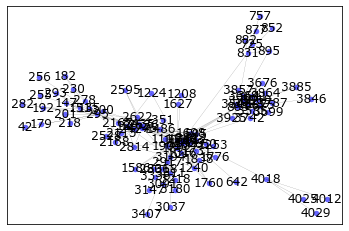

100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3473.94it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 2  (without edges' weights and self loops)


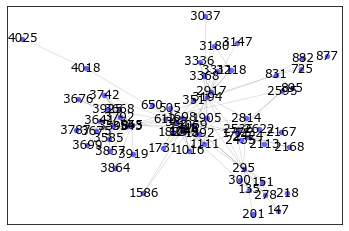

100%|████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 5600.54it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 3  (without edges' weights and self loops)


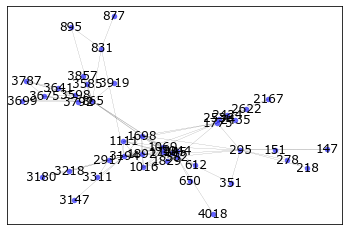

100%|███████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 11034.34it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 4  (without edges' weights and self loops)


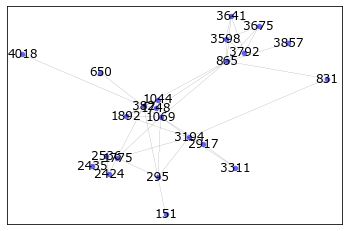

100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 7684.94it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 5  (without edges' weights and self loops)


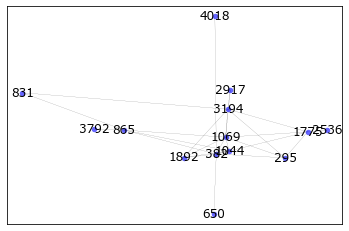

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 7018.92it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 6  (without edges' weights and self loops)


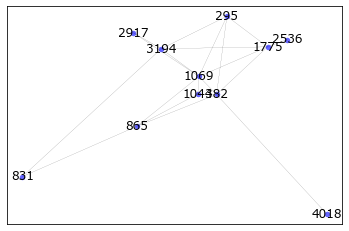

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11040.28it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 7  (without edges' weights and self loops)


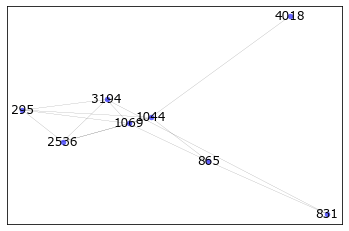

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8019.70it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 8  (without edges' weights and self loops)


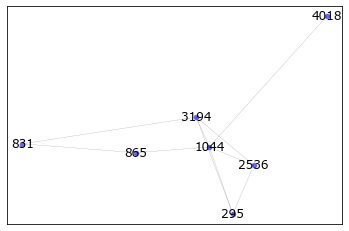

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7029.00it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Graph after passage 9  (without edges' weights and self loops)


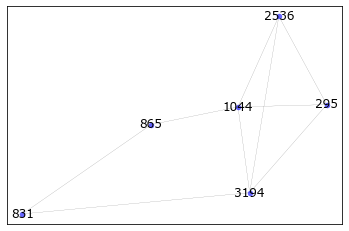

100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


In [21]:
new_graph, communities_hypernodes, communities_nodes = louvain(graph)

In [22]:
print(f'We found {len(set(communities_nodes[-1].values()))} communities.')

We found 6 communities.


In [23]:
import community
louvain_communities = community.best_partition(graph)
nb_louvain_communities = len(set(louvain_communities.values()))
louvain_communities = {k: v for k, v in sorted(louvain_communities.items(), key=lambda item: item[0])} # sort by key (node id)
print(f'There are {nb_louvain_communities} communities according to python-louvain.')

There are 16 communities according to python-louvain.


### Compute the clustering coefficients & plot their distribution

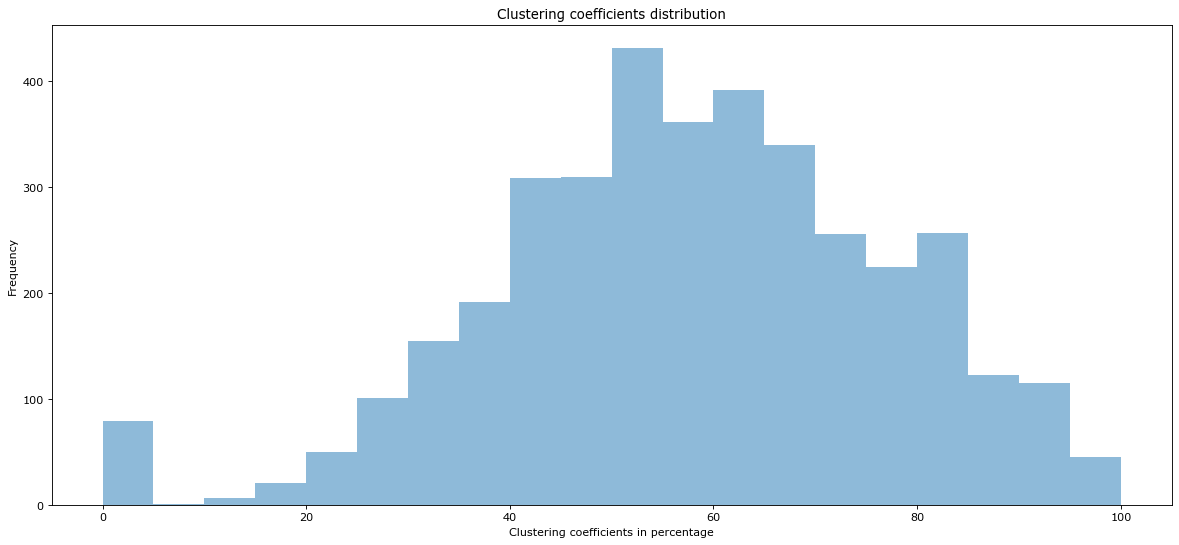

Average clustering coefficient: 0.6056966806603588
Top k=3 users with highest clustering coefficients: {'32': 1.0, '33': 1.0, '35': 1.0}


In [24]:
plot_clustering_coefficients_distribution(clustering_coefficient(graph))

print('Average clustering coefficient:', average_clustering_coefficient(graph))
print('Top k=3 users with highest clustering coefficients:', clustering_coefficient(graph, top_k=3))

Best value for k could be set to ~40 (or ~1% of the total number of nodes in the graph) for such a graph. This would give in the users having a clustering coefficient of 90% and higher.

In [25]:
print('Average clustering coefficient according to Networkx:', nx.average_clustering(graph))
#nx.clustering(graph)

Average clustering coefficient according to Networkx: 0.6055467186200866


### Evaluate different random walk strategies to spread a message across the network

In [26]:
starting_node = list(graph.nodes())[0]
steps = 10

rw_result_strategy_random = random_walk(graph, starting_node, steps, rw_strategy_random)
rw_result_strategy_degree = random_walk(graph, starting_node, steps, rw_strategy_degree)
rw_result_stategy_connected_neighbors = random_walk(graph, starting_node, steps, rw_strategy_connected_neighbors)

print('Percentage of visited communities with full random rw strategy and 10 steps:', percentage_visited_communities(rw_result_strategy_random, communities_nodes[-1]), '%')
print('Percentage of visited communities with the degree based rw strategy and 10 steps:', percentage_visited_communities(rw_result_strategy_degree, communities_nodes[-1]), '%')
print('Percentage of visited communities with the connected neighbors rw strategy and 10 steps:', percentage_visited_communities(rw_result_stategy_connected_neighbors, communities_nodes[-1]), '%')

Percentage of visited communities with full random rw strategy and 10 steps: 16.666666666666664 %
Percentage of visited communities with the degree based rw strategy and 10 steps: 16.666666666666664 %
Percentage of visited communities with the connected neighbors rw strategy and 10 steps: 16.666666666666664 %


In [29]:
print('%32s  %6s  %5s' % ('Strategy', '# Steps', 'Average percentage of visited communities'))
for steps in range(3,13,2):
    for strategy in [rw_strategy_random, rw_strategy_degree, rw_strategy_connected_neighbors]:
        print('%32s  %7i  %5.2f' % (strategy.__name__, steps, statistics.mean([percentage_visited_communities(random_walk(graph, starting_node, steps, strategy), communities_nodes[-1]) for _ in range(3)])))

                        Strategy  # Steps  Average percentage of visited communities
              rw_strategy_random        3  16.67
              rw_strategy_degree        3  16.67
 rw_strategy_connected_neighbors        3  16.67
              rw_strategy_random        5  16.67
              rw_strategy_degree        5  22.22
 rw_strategy_connected_neighbors        5  16.67
              rw_strategy_random        7  22.22
              rw_strategy_degree        7  22.22
 rw_strategy_connected_neighbors        7  16.67
              rw_strategy_random        9  16.67
              rw_strategy_degree        9  22.22
 rw_strategy_connected_neighbors        9  16.67
              rw_strategy_random       11  16.67
              rw_strategy_degree       11  16.67
 rw_strategy_connected_neighbors       11  16.67


We observe that the degree based strategy tends to visit more communities than the two others.

## Visualization

### Visualize the output of Louvain by coloring the nodes according to their assigned Communities

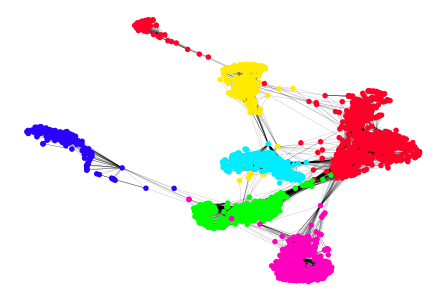

In [30]:
pos = nx.spring_layout(graph)
draw_graph_with_communities(graph, communities_nodes[-1], pos)

### Visualize the output of applying Random Walk algorithm, by highlighting the sequence of nodes selected in a path

<IPython.core.display.Javascript object>


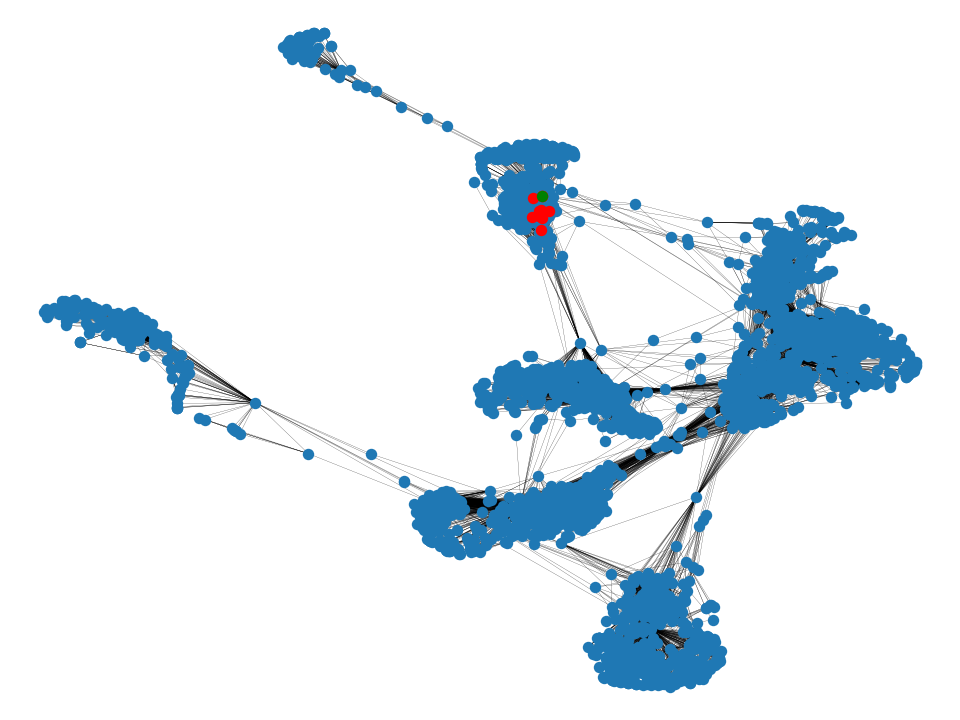

In [31]:
%matplotlib notebook
draw_graph_with_path(graph, rw_result_strategy_degree, pos)